# 1. Introduction

In preceding notebooks, we performed preliminary assessments of data quality and refined the question to be answered. We found a small number of data values that gave clear choices about whether to replace values or drop a whole row. We filtered various features depending on how much is they effect the loan status. We realized that the loan status is not affected significantly by the state the borrowers are located. In this notebook, we first perform further pre-processing and feature engineering, and then we apply serveral machine learning methods to predict the loan status, in terms of fully-paid or default. Note that this will be a binary classifications. We have incorporated the processing and model parts in this section.

The models studied here include the following:

1. Logistic regression

2. Decision tree

3. Random Forest

4. Gradient boosting



# 2. Imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle


### Project Directory

In [2]:
os.getcwd()
PROJ_ROOT = os.path.join(os.pardir, os.pardir)
cleaned_EDA = os.path.join(PROJ_ROOT, 'data', 'explored_cleaned', 'cleaned_data_EDA.csv')
sys.path.append(cleaned_EDA)

#### Import user defined functions

In [3]:
udf_path = os.path.join(PROJ_ROOT, 'src')
sys.path.append(udf_path)
import features.feature_builder as fb

# 3. Load the data<a class='anchor' id='Load_Data'></a>

Using the pd.read_csv, we load the data

In [4]:
df = pd.read_csv(cleaned_EDA)

In [5]:
df.columns

Index(['Unnamed: 0', 'dti', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'inq_last_6mths', 'open_acc', 'mort_acc',
       'annual_inc', 'sub_grade', 'loan_status', 'installment', 'int_rate',
       'term', 'revol_bal', 'emp_length', 'home_ownership', 'num_rev_accts',
       'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt', 'purpose',
       'verification_status', 'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs',
       'delinq_amnt', 'util', 'Credit Length (year)', 'fico_score'],
      dtype='object')

In [6]:
df = df.drop(columns=['Unnamed: 0'])

# Do we have a balanced dataset?

According to [imbalanced](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), a data set is imbalanced if the minority class makes a small percentage of the data set. 

What counts as imbalanced? The answer could range from mild to extreme, as the table below shows.

Degree of imbalance	Proportion of Minority Class
Mild	20-40% of the data set
Moderate	1-20% of the data set
Extreme	<1% of the dataulted

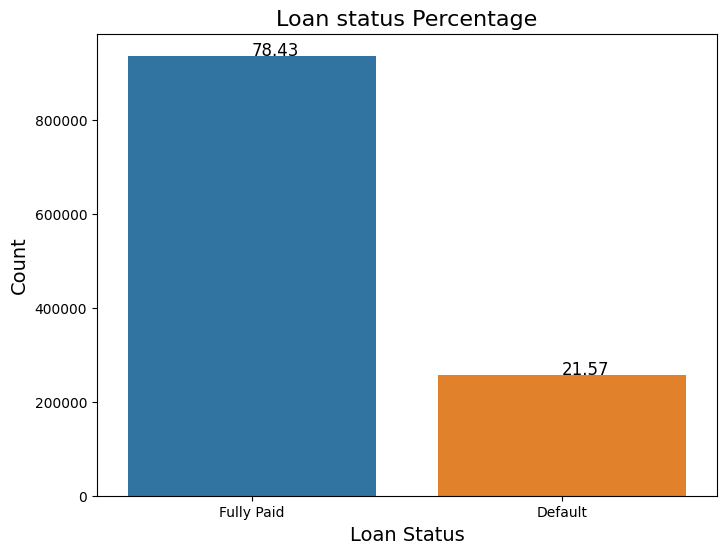

In [7]:
fig,ax=plt.subplots(figsize=(8,6))
sns.countplot(x='loan_status', data=df, hue='loan_status', ax=ax)
ax.set_xlabel('Loan Status', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title("Loan status Percentage", fontsize=16)

p=ax.patches
for i in range(0,2,1):
    x1,y1 = p[i].get_xy()
    x = x1 + p[i].get_width() / 2
    y = y1 + p[i].get_height()
    per = y / df.shape[0]
    plt.text(x,y, round(per*100,2), fontsize=12)
    
plt.show()

Default loans count for 22% of our data set. Therefore, our data is mildly imbalance. We decide to use the true-distribution of the data and avoid using techniques for imbalanced datasets such as undersampling.

# 5. Preprocessing of data before modeling

The preprocessing include several steps. The most important step is to transform the categorial columns as most of ML methods
work with numerical data.

#### One Hot Encoder

In [234]:
# define X and Y variables
X = df.drop(columns=['loan_status', 'verification_status'])
y = df['loan_status']
col_num = X.shape[1]

In [235]:
# Which variables are categorial columns
obj_cols = fb.get_data_type(X)['object_dtype']
obj_cols

['sub_grade', 'term', 'emp_length', 'home_ownership', 'purpose']

In [236]:
# One Hot Encoder
enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[obj_cols]).toarray())
feature_names = enc.get_feature_names_out(input_features=obj_cols)
enc_df.columns = feature_names
X.drop(columns=obj_cols, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

Xcol_names = X.columns
ycol_name =['loan_status']

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 26 to 75


In [237]:
# rename emp_length_< 1 year to other names
X.rename(columns = {'emp_length_< 1 year': 'emp_length_lessthan1 year'}, inplace=True)

In [238]:
X.columns

Index(['dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'inq_last_6mths', 'open_acc', 'mort_acc', 'annual_inc', 'installment',
       'int_rate', 'revol_bal', 'num_rev_accts', 'pub_rec_bankruptcies',
       'tax_liens', 'loan_amnt', 'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs',
       'delinq_amnt', 'util', 'Credit Length (year)', 'fico_score',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'term_ 6

In [291]:
# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

In [292]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

# Change back to panads dataframe
X_train = pd.DataFrame(X_train, columns=Xcol_names)
X_test = pd.DataFrame(X_test, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)
y_test = pd.DataFrame(y_test, columns=ycol_name)

,loan_status
0,Fully Paid
1,Fully Paid
2,Default
3,Default
4,Default


# 6. What metric shall we use?

Given that the data is mildly imbalanced, accuracy score is not a good metrics to evaluate performance of a model. It is [recommended](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html#:~:text=1%20Use%20the%20right%20evaluation%20metrics.%20Applying%20inappropriate,keep%20the%20models%20as%20a%20fixed%20component.%20) to use evaluation metrics such as precision, recal, f1 score or balanced accuracy. We use "balanced accuracy" as our evaluation metrics to compare model performance. 


# 7. Modeling

Following classifiers will be trained on the test data:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost

Steps that we follow for each model include:

1. Make a pipeline, that includes the model and scaling steps and then use cross valiadtion to train a general model. 

2. Grid search to find the hyperparameters.

3. Train the model with the tuned hyperparameters and study feature importance

After training all 4 models, I will use them on the test data and will compare the results to choose the model with the most predictive power.

## Logistic regression <a class='anchor' id='lr'></a>

### Make a pipeline for logistic regression classifier <a class='anchor' id='pllr'></a>

Using make_pipeline, a pipeline is created to train logistic regression classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

To avoid overfitting, we use cross validation with 5 folds.

In [80]:
# General lr
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)

lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
lr_cv_scores = lr_cv_results['test_score']

print('Balanced accuaracy scores of 5 fold logistic regression are: ', lr_cv_scores)
print('Mean and standard deviation of balanced accuaracy scores of 5 fold logistic regression is: ', lr_cv_scores.mean(),  ' ,' , lr_cv_scores.std())

Balanced accuaracy scores of 5 fold logistic regression are:  [0.65351251 0.65178022 0.65211189 0.65216277 0.65439433]
Mean and standard deviation of balanced accuaracy scores of 5 fold logistic regression is:  0.6527923447366067  , 0.0009968717271022964


### Hyperparameter search using GridSearchCV for logistic regression <a class='anchor' id='gdlr'></a>

Logistic regression has several parameters to tune. These parameters are shown by using get_params().keys(). Given the computing power constraints, a small though important number of features are chosen to tune. These parameters are learning rate and penalty.

In [81]:
# Define a set of parameters for grid search
grid_params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='balanced_accuracy')

### Best Logistic Regression model and feature importance <a class='anchor' id='bestlr'></a>

Now that we know the best hyperparameters for Logistic Regression, we will train the model with the tuned hyperparameteres and look at the cofficients of features to find out the most influential features.

In [82]:
# Get the best parameters
print(lr_grid_cv.best_params_)
lr_gd_best_score = lr_grid_cv.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression is: ', lr_gd_best_score)

{'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression is:  0.6529780235238014


Grid serach and tuning hyperparameters did not make a significant change on the initial classification. Next by using the best estimator, we get the coefficients of each feature and will plot feature importance figure.

In [83]:
X.columns

Index(['dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'inq_last_6mths', 'open_acc', 'mort_acc', 'annual_inc', 'installment',
       'int_rate', 'revol_bal', 'num_rev_accts', 'pub_rec_bankruptcies',
       'tax_liens', 'loan_amnt', 'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs',
       'delinq_amnt', 'util', 'Credit Length (year)', 'fico_score',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'term_ 6

Text(57.26019531249999, 0.5, 'Feature')

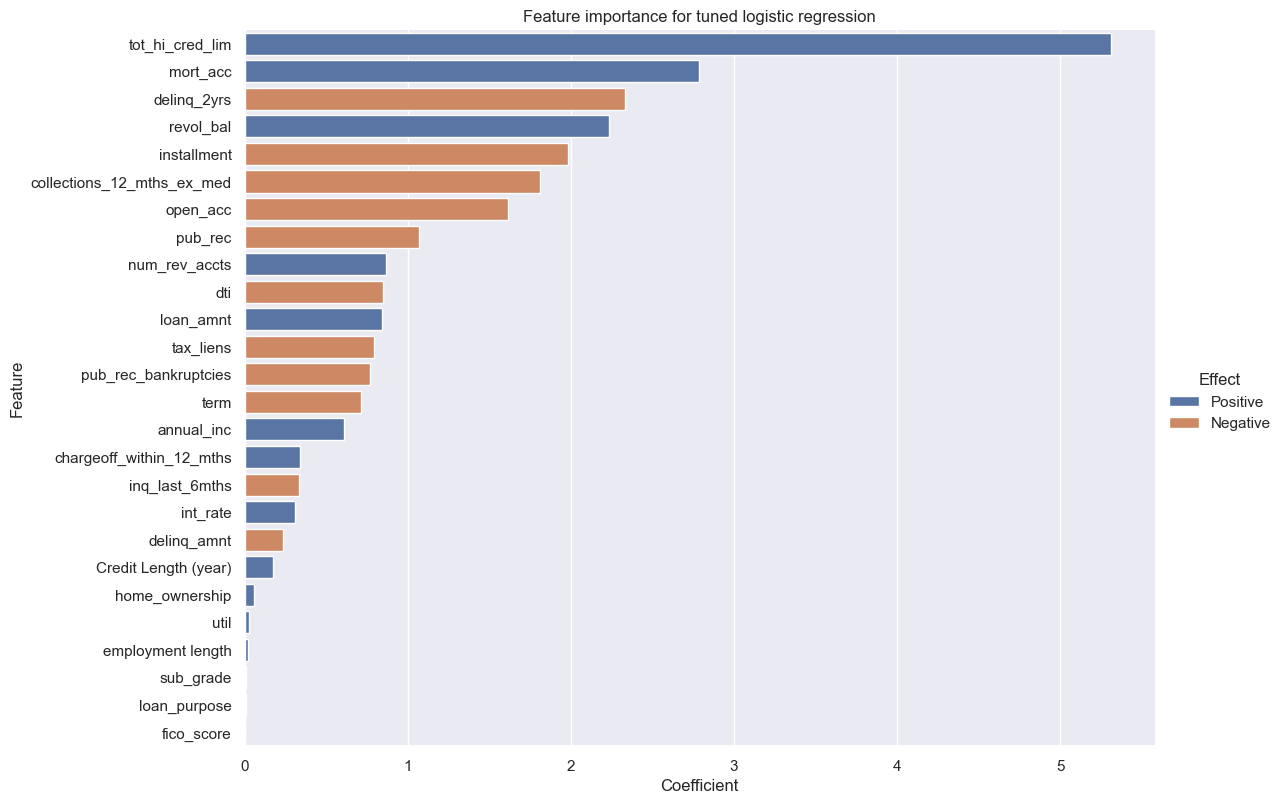

In [325]:
model_features = pd.DataFrame(lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO_mask = model_features.index.str.contains('home')
HO = model_features.loc[HO_mask,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp_mask = model_features.index.str.contains('emp_length')
Emp = model_features.loc[Emp_mask,:]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub_mask = model_features.index.str.contains('sub_grade')
Sub = model_features.loc[Sub_mask,:]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

#VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
#vs = pd.DataFrame({'Importance': VS.mean()})
#vs.index = ['Verification status']
Purp_mask = model_features.index.str.contains('purpose')
Purp = model_features.loc[Sub_mask,:]
Purp = pd.DataFrame({'Importance': Purp.mean()})
Purp.index = ['loan_purpose']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'fico_score',:], term, HO, Emp, sub, Purp])
title = 'Feature importance for tuned logistic regression'
model_features['Effect'] = 'Positive'
model_features.loc[model_features['Importance'] < 0, 'Effect'] = 'Negative'
model_features['Absolute effect'] = abs(model_features['Importance'])
data = model_features.sort_values(by='Absolute effect', ascending=False)

# Plot feature importance
sns.catplot(y= data.index, x='Absolute effect', hue='Effect', kind='bar', data=data, height=8, aspect=12/8)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')

For the logistic regression, the balanced accuracy score is 53%. 
We can see that, total _high credit limit_, number of _mortage accounts_ followed by amount of _revoling balance_ are the most significant features, followed by number of _revolving accounts_ and _loan amount_. 

Furthermore, the _annual income_, _sub grade_, _employment length_ and _home ownership_ has very little effect on logistic regression classification result.


In the next step, we will train a decision tree classifier.

In [85]:
## Save the best logistic regression model
best_model_lr = lr_grid_cv.best_estimator_.named_steps.logisticregression
best_model_lr.version = '1.0'
best_model_lr.X_columns = [col for col in X_train.columns]
best_model_lr.build_datetime = datetime.datetime.now()


with open('lr_model', 'wb') as file:
    pickle.dump(best_model_lr,file)

## Decision tree classifier <a class='anchor' id='dt'></a>
 


### Make a pipeline for decision tree

Using make_pipeline, a pipeline is created to train decision tree classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [242]:
pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

cv_results = cross_validate(pipeTree, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.56808304 0.57110399 0.56939975 0.56574891 0.57079319]
0.5690257762131854 0.0019600590051151645


 
Decision tree balanced accuracy score before hyperparameter tuning is 57%, which is worse than logistic regression. Next we will do hyperparameter tuning.

### Hyperparameter search for decision tree classifier <a class='anchor' id='gddt'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [243]:
# Define grid parameters

grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_depth': [3, 6, 9, 12, 15]}

In [244]:
# Perform grid search to find hyperparameters of decision tree

tree_grid_cv = GridSearchCV(pipeTree, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
tree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               15]},
             scoring='balanced_accuracy')

### Decision tree classifier with best parameters <a class='anchor' id='bestdt'></a>

We access the best parameters by using grid.best_params_

In [245]:
tree_grid_cv.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 9}

We fit a decision tree to the training data by using the best hyperparameters and then, we will look at the importance of the features.

In [246]:
BestTree = tree_grid_cv.best_estimator_
pipeTreeBest = make_pipeline(
    MinMaxScaler(),
    BestTree)

cv_results = cross_validate(pipeTreeBest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print('Balanced accuaracy scores of 5 fold decision tree are: ', cv_scores)
print('Mean and standard deviation of balanced accuaracy scores of 5 fold decision tree is: ', cv_scores.mean(),  ' ,' , cv_scores.std())

Balanced accuaracy scores of 5 fold decision tree are:  [0.64587535 0.64561083 0.64720454 0.64268563 0.6443727 ]
Mean and standard deviation of balanced accuaracy scores of 5 fold decision tree is:  0.6451498100048433  , 0.0015255789778833774


## Visualize the resulting tree

In [247]:
Tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=9, random_state=47)
#Tree = tree.DecisionTreeClassifier()

Tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=47)

It can be seen that after hyperparameter tuning, the balanced accuracy of the decision tree model reached 65%. The hyperparameter tuning increased the score from 0.57 to 0.65. In the next step, we will plot the tree as well as the feature importance figure.

In [186]:
type(graph)

list

<class 'list'>


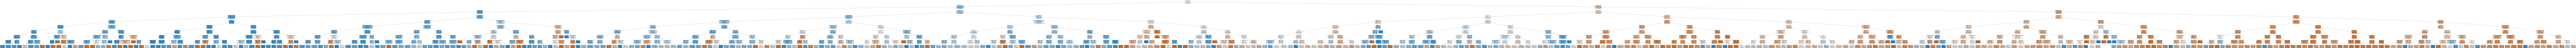

In [248]:
from sklearn.tree import export_graphviz
from io import StringIO  
import os     
from IPython.display import Image
import pydot
import graphviz
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz\bin'


# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(Tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydot.graph_from_dot_data(dot_data.getvalue())
print(type(graph))
#graph, = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### Feature importance assessment in the decision tree classifier <a class='anchor' id='fidt'></a>

Using the "tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_", we access the feature importance values and plot them.

Text(35.5755787037037, 0.5, 'Feature')

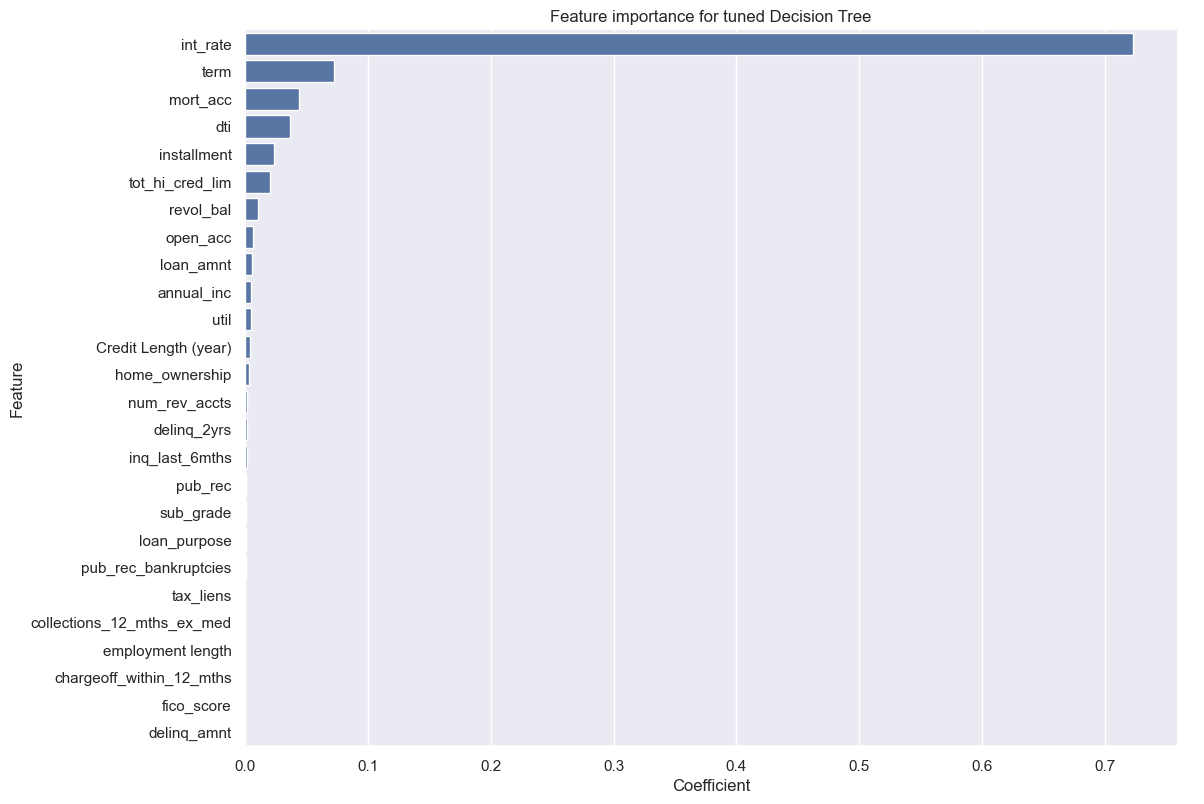

In [326]:
model_features = pd.DataFrame(tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO_mask = model_features.index.str.contains('home')
HO = model_features.loc[HO_mask,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp_mask = model_features.index.str.contains('emp_length')
Emp = model_features.loc[Emp_mask,:]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub_mask = model_features.index.str.contains('sub_grade')
Sub = model_features.loc[Sub_mask,:]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

Purp_mask = model_features.index.str.contains('purpose')
Purp = model_features.loc[Sub_mask,:]
Purp = pd.DataFrame({'Importance': Purp.mean()})
Purp.index = ['loan_purpose']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'fico_score',:], term, HO, Emp, sub, Purp])
title = 'Feature importance for tuned Decision Tree'
data = model_features.sort_values(by='Importance', ascending=False)

# Plot feature importance
sns.catplot(y= data.index, x='Importance', kind='bar', data=data, height=8, aspect=12/8)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')



For the decision tree classifier, the balanced accuracy is 65% and according to the feature importance plot, _interest rate_, _loan term_ (either 30 month or 60 month), _number of mortages_, _debt to income ratio_, _installment_, _high Fico score_, _revolving balance_ and _low Fico score_ are the most influential parameters in decision tree classifier. 


Interest rate has a more significant effect than the other parameters. 


Furthermore,_sub grade_,number of _tax liens_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

In [256]:
## Save the best decision model
best_model_dt = tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier
best_model_dt.version = '1.0'
best_model_dt.X_columns = [col for col in X_train.columns]
best_model_dt.build_datetime = datetime.datetime.now()


with open('dt_model', 'wb') as file:
    pickle.dump(best_model_dt,file)

## Random forest classifier <a class='anchor' id='rf'></a>

### Make a pipeline for random forest classifier <a class='anchor' id='plrf'></a>

Using make_pipeline, a pipeline is created to train random forest classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [257]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
cv_results = cross_validate(pipeRF, X_train, y_train, scoring='balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

[0.65115568 0.65172434 0.65316558 0.65288248 0.64990274]
0.6517661625446765 0.0011875445743161227


### Hyperparameter search for random forest classifier

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [258]:
# Define a grid for hyperparameter tuning with GridSearchCV
param_grid = { 
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth' : [3, 6, 9],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}

rf_grid_cv_0  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)
rf_grid_cv_0.fit(X_train, y_train)
rf_grid_cv_0.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 150}

As seen above, best parameters for random forest are: 

1. Criterion: gini
2. max_depth: 9
3. n_estimator: 150

The search grid was:

'randomforestclassifier__n_estimators': [50, 100, 150],
'randomforestclassifier__max_depth' : [3, 6, 9],
'randomforestclassifier__criterion' :['gini', 'entropy']

It is not clear if we increase _n_estimator_ or _max_depth_, how the classifier performs. Due to lack of computational power, we will do grid search for random forest parameter in two steps. First we tune n_esimator and we search list of [150, 200, 300, 500, 700, 1000] and then we use the tune _n_estimator_ in the next grid search for max_depth and we search list of [6, 9, 15, 25, 35].



In [259]:
# First step: tuning n_estimator
param_grid = { 
    'randomforestclassifier__n_estimators': [150, 200, 300, 500, 700, 1000],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [9]
}
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
rf_grid_cv_1  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv_1.fit(X_train, y_train)
rf_best_cv_1_results = cross_validate(rf_grid_cv_1.best_estimator_, X_train, y_train, cv=5, scoring='balanced_accuracy')
rf_best_scores = rf_best_cv_1_results['test_score']
print(rf_best_scores)
print(rf_best_scores.mean(), rf_best_scores.std())

rf_grid_cv_1.best_params_

[0.65048963 0.65169497 0.65148732 0.65362987 0.64823844]
0.6511080458168024 0.0017586905088521076


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 1000}

Now, we use _n_estimator_ = 1000 and tune _max_depth_.



It can be seen that the abalanced accuracy score for the tuned random forest is 65%, very similar to the tune decision tree and logistic regression. In the next step, we plot the feature importance to study effect of features.

### Feature importance assessment of random forest classifier



Using rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_, we access the values and plot them

Text(35.5755787037037, 0.5, 'Feature')

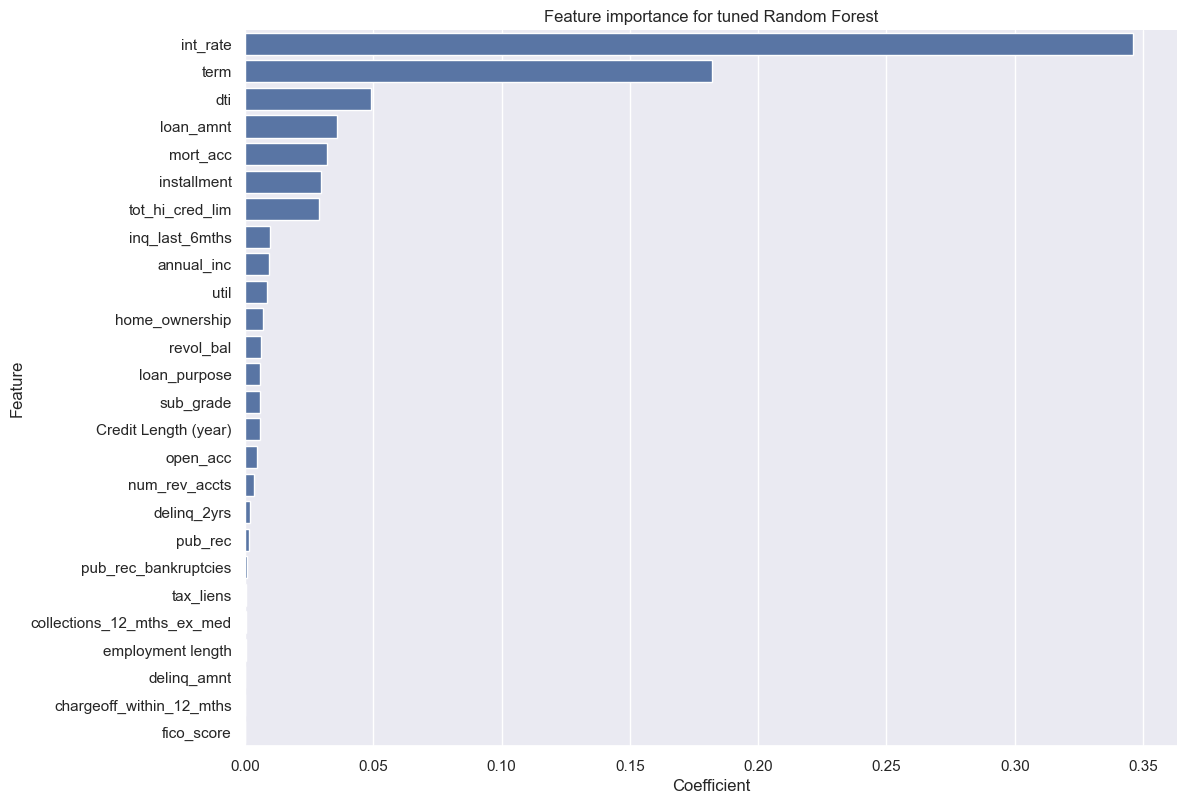

In [327]:
# Plot feature importance for random forest
model_features = pd.DataFrame(rf_grid_cv_1.best_estimator_.named_steps.randomforestclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO_mask = model_features.index.str.contains('home')
HO = model_features.loc[HO_mask,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp_mask = model_features.index.str.contains('emp_length')
Emp = model_features.loc[Emp_mask,:]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub_mask = model_features.index.str.contains('sub_grade')
Sub = model_features.loc[Sub_mask,:]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

Purp_mask = model_features.index.str.contains('purpose')
Purp = model_features.loc[Sub_mask,:]
Purp = pd.DataFrame({'Importance': Purp.mean()})
Purp.index = ['loan_purpose']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'fico_score',:], term, HO, Emp, sub, Purp])
title = 'Feature importance for tuned Random Forest'
data = model_features.sort_values(by='Importance', ascending=False)

# Plot feature importance
sns.catplot(y= data.index, x='Importance', kind='bar', data=data, height=8, aspect=12/8)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')



For tuned random forest, the balanced accuracy score is 65%, very similar to logistic regression and decision tree.

As shown in the plot,  _interest rate_, _loan term_(either it is 30 month or 60 month), _higher Fico score_ and _low Fico score_, _debt to income ratio_ , _number of mortages_, _funded amount_ and _installment_ are the most influential parameters.

It is worth mentioning that the decision tree reached to almost similar conclusion in the previous section. In a decision tree classifier, the most influential parameters were interest rate, loan term(either it is 30 month or 60 month loan), number of mortages, debt to income ratio, installment, Low Fico score, revolving balance and high Fico score.  

Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

In [264]:
## Save the best random forest model
best_model_rf = rf_grid_cv_1.best_estimator_.named_steps.randomforestclassifier
best_model_rf.version = '1.0'
best_model_rf.X_columns = [col for col in X_train.columns]
best_model_rf.build_datetime = datetime.datetime.now()


with open('rf_model', 'wb') as file:
    pickle.dump(best_model_rf,file)

## Gradient boosting classifier <a class='anchor' id='GB'></a>

### Make a pipeline for gradient boosting classifier <a class='anchor' id='plgb'></a>

Using make_pipeline, a pipeline is created to train gradient boosting classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [293]:
# One Hot Encoder for y_train
enc_1 = enc.fit(y_train)
enc_y_train = pd.DataFrame(enc_1.transform(y_train).toarray())
enc_y_train.columns = ['loan_status']
y_train.drop(columns='loan_status', inplace=True)
# merge with main df bridge_df on key values
y_train =(y_train.join(enc_y_train)).astype('int')

In [294]:
# One Hot Encoder for y_test
enc_y_test = pd.DataFrame(enc_1.transform(y_test).toarray())
enc_y_test.columns = ['loan_status']
y_test.drop(columns='loan_status', inplace=True)
# merge with main df bridge_df on key values
y_test =(y_test.join(enc_y_test)).astype('int')

In [300]:
# knowing the classes of the encoded dataframe
print(enc_1.inverse_transform([[0], [1]]))

[['Default']
 ['Fully Paid']]


In [301]:
pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

cv_results = cross_validate(pipeXG, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

[0.65857123 0.65844601 0.6608715  0.66047857 0.66376321]
0.6604261036545227 0.0019338444841746892


Gradient boosting model balanced accuracy score is 66%, which is highest among the models. Decision tree, logistic regression and random forest reached 65% accuracy after tuning.

### Hyperparameter tuning for gradient boosting classifier

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [302]:
pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier(eval_metric='mlogloss'))

parameters = {
    'xgbclassifier__max_depth':[3, 6, 9],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
    }
grid_search_2 = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search_2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=Non...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
                         'xgbclassifier__max_depth': [3, 6, 9]},
             scoring='balanced_accuracy')

In [303]:
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)

{'xgbclassifier__learning_rate': 0.25, 'xgbclassifier__max_depth': 6}
0.6611577108213956


Hyperparameter tuning does not change the result significantly.

In [304]:
# Print best parameters and results
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)

{'xgbclassifier__learning_rate': 0.25, 'xgbclassifier__max_depth': 6}
0.6611577108213956


In [334]:
pipeXGbest = make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate= 0.25, max_depth= 6, eval_metric='mlogloss'))

cv_results = cross_validate(pipeXGbest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.66008137 0.65834886 0.66207693 0.66247446 0.66280692]
0.6611577108213956 0.001693922577202973


### Gradient boosting feature importance assessment 

Text(0, 0.5, 'Feature')

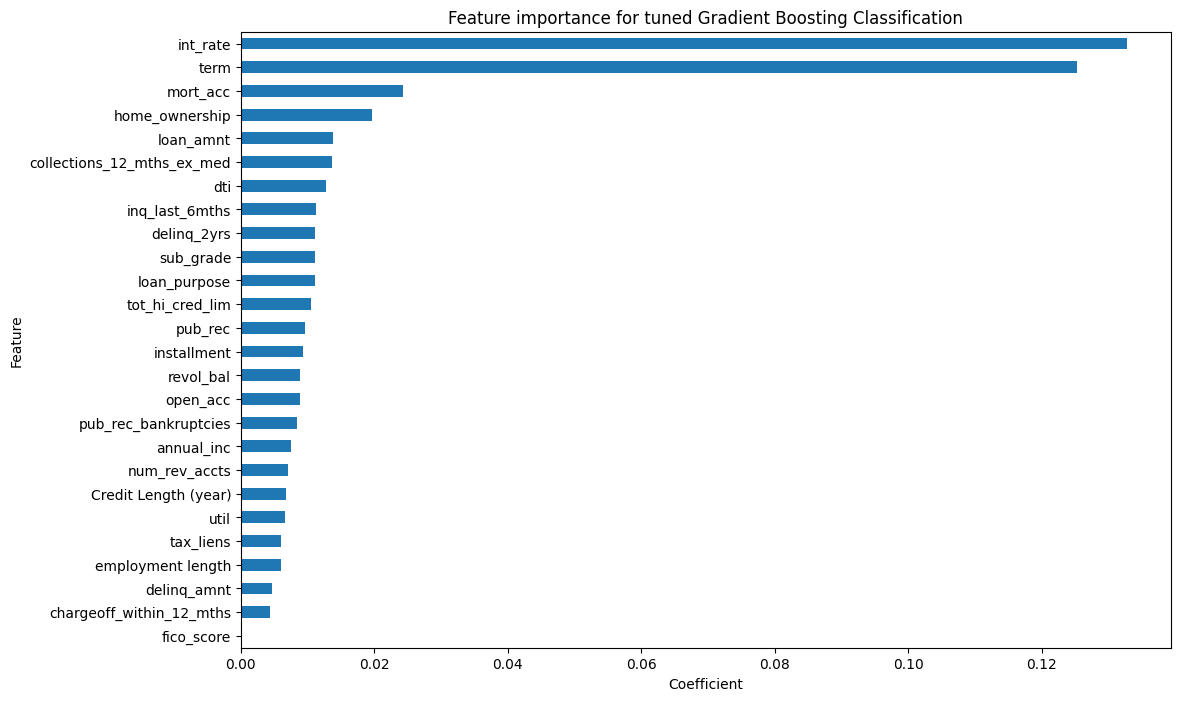

In [321]:
#model_features = pd.DataFrame(pipeXGbest.named_steps['xgbclassifier'].feature_importances_.T)
model_features = pd.DataFrame(grid_search_2.best_estimator_.named_steps.xgbclassifier.feature_importances_.T)

model_features.index = X.columns
model_features.columns=['Importance']

HO_mask = model_features.index.str.contains('home')
HO = model_features.loc[HO_mask,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp_mask = model_features.index.str.contains('emp_length')
Emp = model_features.loc[Emp_mask,:]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub_mask = model_features.index.str.contains('sub_grade')
Sub = model_features.loc[Sub_mask,:]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

Purp_mask = model_features.index.str.contains('purpose')
Purp = model_features.loc[Sub_mask,:]
Purp = pd.DataFrame({'Importance': Purp.mean()})
Purp.index = ['loan_purpose']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'fico_score',:], term, HO, Emp, sub, Purp])
title = 'Feature importance for tuned Gradient Boosting Classification'
data = model_features.sort_values(by='Importance')

'''
# Plot feature importance
sns.catplot(y= data.index, x='Importance', kind='bar', data=data)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
'''

# Plot feature importance
fig,ax= plt.subplots(figsize=(12,8))
data['Importance'].plot(kind='barh',ax=ax)
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')

According to the balanced accuracy score, gradient boosting is slightly better than previous models. The balanced accuracy score is 67%.

According to the feature importance plot, _interest rate_, _term_, the number of _mortage accounts_ , followed by _high Fico score_, _funded amount_, -home ownership_, _debt to income ratio_ and income _verification status_  are the most influential parameters in the classification. _interset rate_ and _term_ have more significant effect compared to other parameters.

Among the parameters, _low Fico score_ has the lowest effect on classification.

In [337]:
pipeXGbest.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.25,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [309]:
best_model_xg = pipeXGbest.named_steps.xgbclassifier
best_model_xg.version = '1.0'
best_model_xg.X_columns = [col for col in X_train.columns]
best_model_xg.build_datetime = datetime.datetime.now()


with open('XGBoost_model', 'wb') as file:
    pickle.dump(best_model_xg,file)

# Final model selection
    
We first define a function to plot the confussion matrix. Then we apply each model separately on the test data, read the balanced accuracy score, print the classification report and plot the confusion matrix.

In [329]:
pipe = make_pipeline(MinMaxScaler(), best_model_lr)
pipe.fit(X_train, y_train)
y_prob_lr = pipe.predict_proba(X_test)[:,1]

pipe = make_pipeline(MinMaxScaler(), best_model_dt)
pipe.fit(X_train, y_train)
y_prob_dt = pipe.predict_proba(X_test)[:,1]

pipe = make_pipeline(MinMaxScaler(), best_model_rf)
pipe.fit(X_train, y_train)
y_prob_rf = pipe.predict_proba(X_test)[:,1]

pipe = make_pipeline(MinMaxScaler(), best_model_xg)
pipe.fit(X_train, y_train)
y_prob_xg = pipe.predict_proba(X_test)[:,1]


FalsePositiveRate_lr, TruePositiveRate_lr, threshold = metrics.roc_curve(y_test, y_prob_lr, pos_label=1)
FalsePositiveRate_dt, TruePositiveRate_dt, threshold = metrics.roc_curve(y_test, y_prob_dt, pos_label=1)
FalsePositiveRate_rf, TruePositiveRate_rf, threshold = metrics.roc_curve(y_test, y_prob_rf, pos_label=1)
FalsePositiveRate_xg, TruePositiveRate_xg, threshold = metrics.roc_curve(y_test, y_prob_xg, pos_label=1)

roc_auc_lr = metrics.auc(FalsePositiveRate_lr, TruePositiveRate_lr)
roc_auc_dt= metrics.auc(FalsePositiveRate_dt, TruePositiveRate_dt)
roc_auc_rf= metrics.auc(FalsePositiveRate_rf, TruePositiveRate_rf)
roc_auc_xg= metrics.auc(FalsePositiveRate_xg, TruePositiveRate_xg)



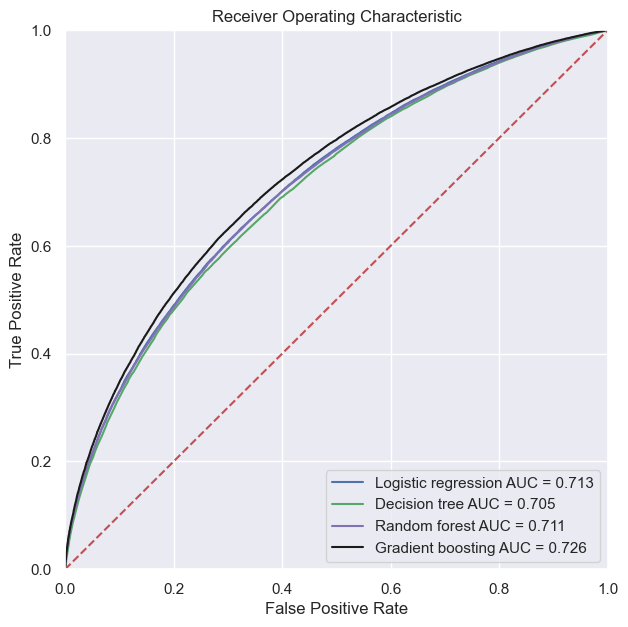

In [330]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Receiver Operating Characteristic')
ax.plot(FalsePositiveRate_lr, TruePositiveRate_lr,'b', label = 'Logistic regression AUC = %0.3f' % roc_auc_lr)
ax.plot(FalsePositiveRate_dt, TruePositiveRate_dt, 'g', label = 'Decision tree AUC = %0.3f' % roc_auc_dt)
ax.plot(FalsePositiveRate_rf, TruePositiveRate_rf, 'm', label = 'Random forest AUC = %0.3f' % roc_auc_rf)
ax.plot(FalsePositiveRate_xg, TruePositiveRate_xg, 'k', label = 'Gradient boosting AUC = %0.3f' % roc_auc_xg)

ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

In order to choose the best model, we looked at models' balanced accuracy score on the training set.

In [331]:
Score_result = pd.DataFrame({'Logistic regression': [0.6533, .0012], 'Decision tree': [0.6481, 0.0019], "Random forest": [.6532, .0018], "XGBoost": [.6627, .0007]})
Score_result.index = ['Mean', 'Standard deviation']
Score_result

,Logistic regression,Decision tree,Random forest,XGBoost
Mean,0.6533,0.6481,0.6532,0.6627
Standard deviation,0.0012,0.0019,0.0018,0.0007


Based on the above table, XGBoost performs slightly better and we choose it as our predictive model. In the next step, we use the selected model on our test data and plot the confussion matrix and will print the classification report.

In [333]:
type(pipeXGbest)

sklearn.pipeline.Pipeline

In [340]:
y_pred_xg =pd.Series(pipeXGbest.predict(X_test))
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67     77290
           1       0.67      0.65      0.66     77342

    accuracy                           0.67    154632
   macro avg       0.67      0.67      0.67    154632
weighted avg       0.67      0.67      0.67    154632



In [353]:
y_pred_xg = y_pred_xg.map({0: "Default", 1: "Fully Paid"})

In [363]:
y_test = y_test['loan_status'].map({0: "Default", 1: "Fully Paid"})

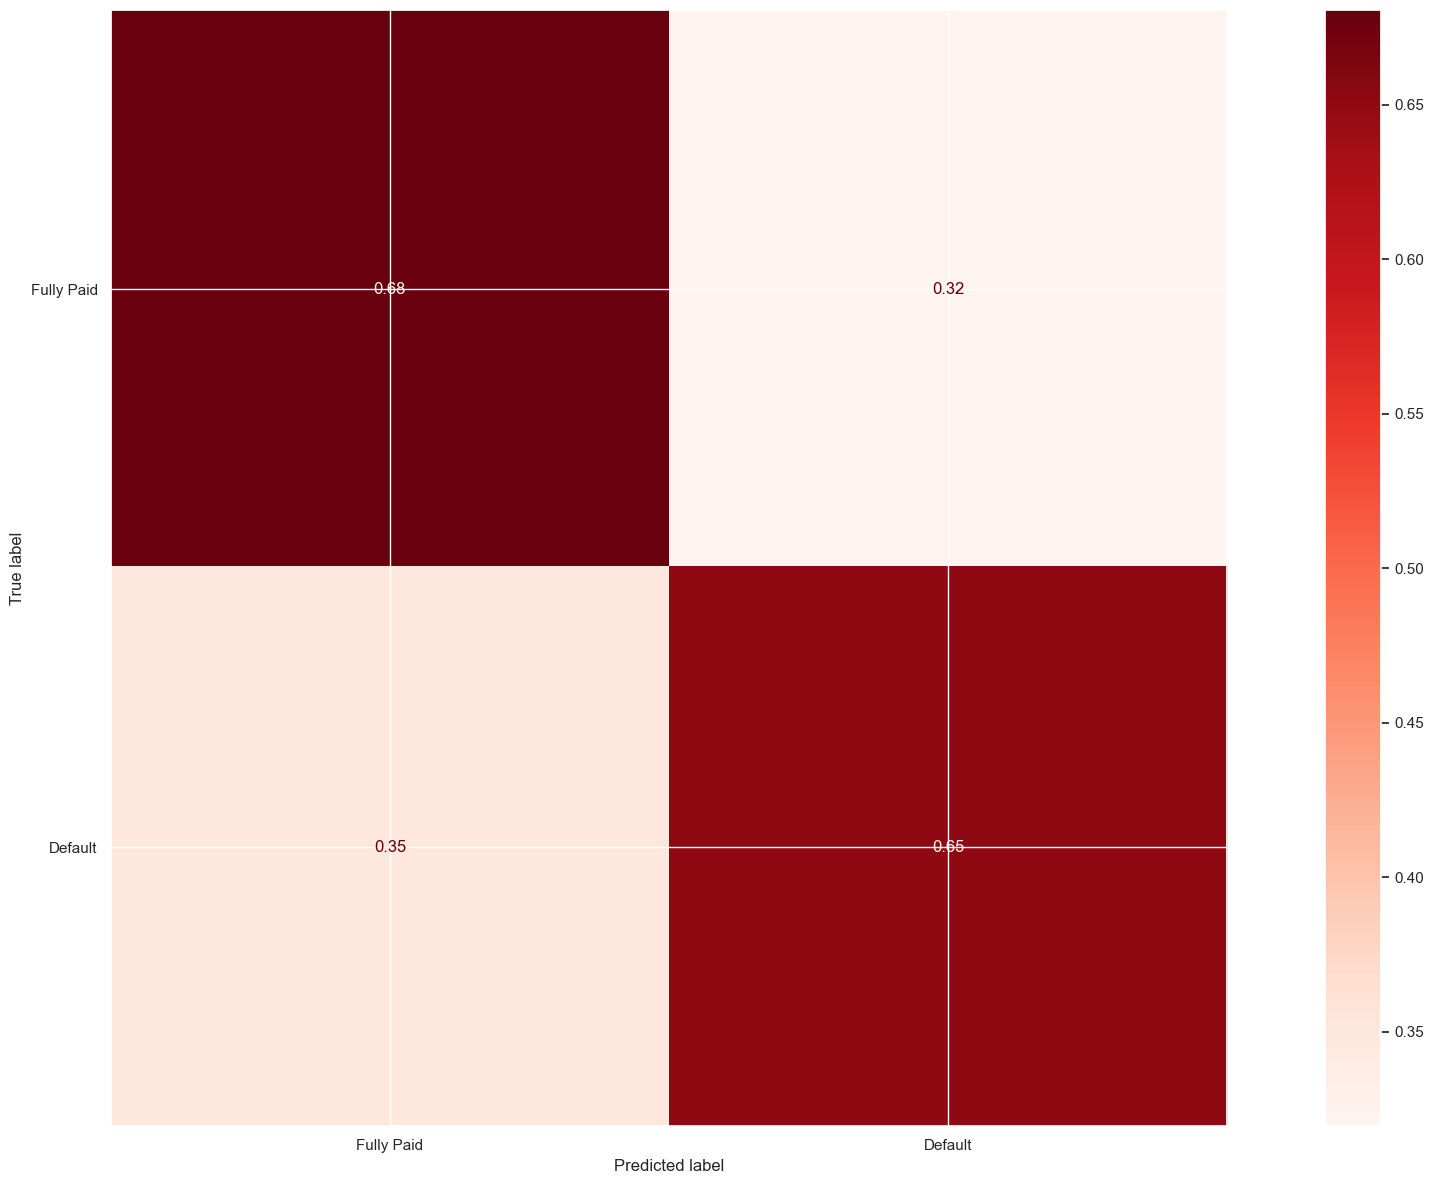

In [368]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = y_pred_xg
cm = confusion_matrix(y_test, y_pred, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Reds')
classes = ['Fully Paid', 'Default']

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Discussion <a class='anchor' id='disc'><a/>
    
    
XGBoost performs slightly better. Its balanced accuracy is 66% versus 65% balanced accuracy of decision tree, logistic regression and random forest classifiers. Comaring f1-score, XGboost reaches 67% versus (decision tree, 64%) and (logistic regression 65%).

# Save the best model <a class='anchor' id='save_model'><a/>
    
We save the model to be able to use it for later.

In [367]:

best_model = pipeXGbest.named_steps.xgbclassifier
best_model.version = '1.0'
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()


with open('XGBoost_model', 'wb') as file:
    pickle.dump(best_model,file)

# Summary

We performed four classification algorithms to predict the default of a loan. The problem at hand is a moderately-balanced 
problem where the percentage of once class is lower than the major class. For instance only 21.6 % of the candidate had defaulted. 
To consider this moderately-balanced classifications, an undersampling approach was taken.

We performed gridsearchcv to tune the hyperparameters by making pipelines that include scaling and model steps). For all classification methods we performed a feature importance analysis. 

__Outcome__:

The classification models showed similar balanced accuracy score of 65%. XGBoost resulted in about 67%. The tree-based models predicted that interest rate, term of loan, and loan amount are the lending club's sources for the default. The applicant's most effective parameters are number of mortgages, debt to income ratio, tot_hi_cred_lim. Based on logistic regression model, tot_hi_cred_lim, mort_acc, and revol_bal were among the most contributing factors. 
